참고한 영상 출처: https://www.youtube.com/watch?v=K_9G29R01kw

In [1]:
import numpy as np   # numercal python. 수치 해석
import pandas as pd   # DataFrame을 쉽게 다루기

import matplotlib.pyplot as plt   # Data visualization
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 5
import seaborn as sns   # Data visualization
sns.set(font_scale = 2.0)   # seaborn 라이브러리 세팅 (plot의 모든 폰트 사이즈를 2.0로 지정)

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime
import utils

import warnings 
warnings.filterwarnings('ignore')   # ignore warning

In [2]:
dt = pd.read_csv('./03_oil_value_ts.csv')
dt.head(10)

,Code,Statistics,Fuel Type,Sulfur Content,Viscosity,Delivery Type,Location,Country,Continent,2022-01-04,...,2024-04-09,2024-04-10,2024-04-11,2024-04-12,2024-04-15,2024-04-16,2024-04-17,2024-04-18,2024-04-19,2024-04-22
0,PPXDK00,CLOSE,Fuel Oil,3.5%,380 CST,FOB,Singapore,Singapore,Asia,434.04,...,491.9,490.855,489.81,492.18,490.35,500.33,500.50,495.32,499.21,489.36
1,PUABC00,CLOSE,Fuel Oil,3.5%,Unknown,FOB,Rotterdam,Netherlands,Europe,430.50,...,474.0,466.750,472.50,479.00,472.00,485.00,482.75,477.00,472.75,467.50
2,PUAFT00,CLOSE,Bunker Fuel Oil,Unknown,380 CST,Delivered,Singapore,Singapore,Asia,447.00,...,507.0,506.000,505.00,507.00,505.00,507.00,512.00,509.00,513.00,507.00
3,AALMZ00,CLOSE,Marine Gasoil,0.5%,Unknown,Delivered,Singapore,Singapore,Asia,684.00,...,810.0,810.000,810.00,803.00,798.00,805.00,801.00,765.00,763.00,760.00
4,PUAFN00,CLOSE,Bunker Fuel Oil,3.5%,380 CST,Delivered,Rotterdam,Netherlands,Europe,439.00,...,475.0,468.000,472.00,496.00,474.00,486.00,483.00,477.00,476.00,469.00
5,AAYWT00,CLOSE,Gasoil,0.1%,Unknown,FOB,ARA Barge,Netherlands/Belgium,Europe,672.25,...,816.0,801.250,800.50,816.75,794.00,795.50,784.75,756.75,759.00,758.50
6,AARTG00,CLOSE,Marine Gasoil,0.1%,Unknown,Delivered,Rotterdam,Netherlands,Europe,670.00,...,805.0,797.000,800.00,805.00,790.00,790.00,780.00,760.00,750.00,750.00
7,AARKD00,CLOSE,Bunker Fuel Oil,Unknown,380 CST,Delivered,Shanghai,China,Asia,505.00,...,504.0,504.500,505.00,510.00,507.00,518.00,521.00,519.00,523.00,517.00
8,AARKE00,CLOSE,Marine Gasoil,0.5%,Unknown,Delivered,Shanghai,China,Asia,785.00,...,850.0,850.000,850.00,846.00,840.00,845.00,845.00,833.00,825.00,820.00
9,PUAFL00,CLOSE,Bunker Fuel Oil,3.5%,380 CST,Delivered,Piraeus,Greece,Europe,468.00,...,540.0,535.000,535.00,535.00,540.00,535.00,540.00,540.00,540.00,540.00


In [3]:
dt = dt[dt['Statistics'] == 'CLOSE'].drop(['Code', 'Country', 'Viscosity'], axis=1)

In [4]:
dt['Fuel Type'] = dt['Fuel Type'] + ' ' + (dt.groupby('Fuel Type').cumcount() + 1).astype(str)
dt

,Statistics,Fuel Type,Sulfur Content,Delivery Type,Location,Continent,2022-01-04,2022-01-05,2022-01-06,2022-01-07,...,2024-04-09,2024-04-10,2024-04-11,2024-04-12,2024-04-15,2024-04-16,2024-04-17,2024-04-18,2024-04-19,2024-04-22
0,CLOSE,Fuel Oil 1,3.5%,FOB,Singapore,Asia,434.04,436.28,438.37,450.78,...,491.90,490.855,489.81,492.18,490.35,500.33,500.50,495.32,499.21,489.36
1,CLOSE,Fuel Oil 2,3.5%,FOB,Rotterdam,Europe,430.50,437.75,444.00,442.00,...,474.00,466.750,472.50,479.00,472.00,485.00,482.75,477.00,472.75,467.50
2,CLOSE,Bunker Fuel Oil 1,Unknown,Delivered,Singapore,Asia,447.00,449.00,451.00,463.00,...,507.00,506.000,505.00,507.00,505.00,507.00,512.00,509.00,513.00,507.00
3,CLOSE,Marine Gasoil 1,0.5%,Delivered,Singapore,Asia,684.00,694.00,698.00,709.00,...,810.00,810.000,810.00,803.00,798.00,805.00,801.00,765.00,763.00,760.00
4,CLOSE,Bunker Fuel Oil 2,3.5%,Delivered,Rotterdam,Europe,439.00,445.00,456.00,456.00,...,475.00,468.000,472.00,496.00,474.00,486.00,483.00,477.00,476.00,469.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,CLOSE,Fuel Oil 5,3.5%,CIF,Med Cargo,Europe,436.00,442.00,449.75,446.75,...,493.50,491.250,498.25,505.50,498.50,506.00,501.75,496.00,492.00,487.75
89,CLOSE,Gasoil 6,0.1%,CIF,Med Cargo,Europe,690.50,706.75,715.25,715.50,...,835.75,831.000,830.50,846.00,822.25,821.75,810.75,779.00,781.00,783.00
92,CLOSE,Gasoil 7,0.1%,CIF,NWE Cargo,Europe,NaN,NaN,NaN,NaN,...,821.25,813.250,813.00,829.00,806.25,808.00,797.50,770.50,773.00,772.25
94,CLOSE,Marine Fuel 3,0.5%,Delivered,Santos,South America,NaN,NaN,NaN,NaN,...,676.00,677.000,670.00,672.00,668.00,670.00,664.00,659.00,661.00,649.00


In [5]:
date_columns = dt.columns[6:]
date_columns

Index(['2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-10',
       '2022-01-11', '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-17',
       ...
       '2024-04-09', '2024-04-10', '2024-04-11', '2024-04-12', '2024-04-15',
       '2024-04-16', '2024-04-17', '2024-04-18', '2024-04-19', '2024-04-22'],
      dtype='object', length=595)

In [6]:
dt_fuel = dt.loc[:, date_columns].T
dt_fuel.columns = dt['Fuel Type']
dt_fuel.index = pd.to_datetime(dt_fuel.index)
dt_fuel

Fuel Type,Fuel Oil 1,Fuel Oil 2,Bunker Fuel Oil 1,Marine Gasoil 1,Bunker Fuel Oil 2,Gasoil 1,Marine Gasoil 2,Bunker Fuel Oil 3,Marine Gasoil 3,Bunker Fuel Oil 4,...,Marine Fuel 2,Bunker Fuel Oil 28,Marine Gasoil 36,Fuel Oil 4,Gasoil 5,Fuel Oil 5,Gasoil 6,Gasoil 7,Marine Fuel 3,Marine Gasoil 37
2022-01-04,434.04,430.50,447.0,684.0,439.0,672.25,670.0,505.0,785.0,468.0,...,569.00,493.0,715.0,427.50,673.75,436.00,690.50,NaN,NaN,NaN
2022-01-05,436.28,437.75,449.0,694.0,445.0,692.25,685.0,508.0,785.0,470.0,...,576.00,495.0,720.0,433.75,690.75,442.00,706.75,NaN,NaN,NaN
2022-01-06,438.37,444.00,451.0,698.0,456.0,701.25,703.0,510.0,785.0,473.0,...,581.50,501.0,730.0,441.50,699.25,449.75,715.25,NaN,NaN,NaN
2022-01-07,450.78,442.00,463.0,709.0,456.0,702.25,700.0,520.0,797.0,475.0,...,581.50,502.0,740.0,438.00,700.25,446.75,715.50,NaN,NaN,NaN
2022-01-10,448.57,437.25,461.0,712.0,451.0,698.75,702.0,515.0,790.0,479.0,...,582.50,505.0,740.0,433.00,698.50,441.75,713.25,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-16,500.33,485.00,507.0,805.0,486.0,795.50,790.0,518.0,845.0,535.0,...,622.25,583.0,853.0,494.00,802.50,506.00,821.75,808.00,670.0,904.0
2024-04-17,500.50,482.75,512.0,801.0,483.0,784.75,780.0,521.0,845.0,540.0,...,614.75,577.0,850.0,489.75,789.25,501.75,810.75,797.50,664.0,900.0
2024-04-18,495.32,477.00,509.0,765.0,477.0,756.75,760.0,519.0,833.0,540.0,...,602.25,570.0,830.0,484.00,758.00,496.00,779.00,770.50,659.0,896.0
2024-04-19,499.21,472.75,513.0,763.0,476.0,759.00,750.0,523.0,825.0,540.0,...,602.00,570.0,825.0,480.00,761.00,492.00,781.00,773.00,661.0,899.0


In [7]:
dt_fuel.isna().sum()

Fuel Type
Fuel Oil 1             0
Fuel Oil 2             0
Bunker Fuel Oil 1      0
Marine Gasoil 1        0
Bunker Fuel Oil 2      0
                    ... 
Fuel Oil 5             0
Gasoil 6               0
Gasoil 7              36
Marine Fuel 3        259
Marine Gasoil 37     259
Length: 82, dtype: int64

In [8]:
# 결측치 컬럼 삭제
dt_fuel = dt_fuel.iloc[:, :-3]
dt_fuel

Fuel Type,Fuel Oil 1,Fuel Oil 2,Bunker Fuel Oil 1,Marine Gasoil 1,Bunker Fuel Oil 2,Gasoil 1,Marine Gasoil 2,Bunker Fuel Oil 3,Marine Gasoil 3,Bunker Fuel Oil 4,...,Marine Gasoil 34,Marine Gasoil 35,Marine Fuel 1,Marine Fuel 2,Bunker Fuel Oil 28,Marine Gasoil 36,Fuel Oil 4,Gasoil 5,Fuel Oil 5,Gasoil 6
2022-01-04,434.04,430.50,447.0,684.0,439.0,672.25,670.0,505.0,785.0,468.0,...,699.0,705.0,561.50,569.00,493.0,715.0,427.50,673.75,436.00,690.50
2022-01-05,436.28,437.75,449.0,694.0,445.0,692.25,685.0,508.0,785.0,470.0,...,715.0,705.0,568.50,576.00,495.0,720.0,433.75,690.75,442.00,706.75
2022-01-06,438.37,444.00,451.0,698.0,456.0,701.25,703.0,510.0,785.0,473.0,...,734.0,705.0,574.00,581.50,501.0,730.0,441.50,699.25,449.75,715.25
2022-01-07,450.78,442.00,463.0,709.0,456.0,702.25,700.0,520.0,797.0,475.0,...,725.0,705.0,573.75,581.50,502.0,740.0,438.00,700.25,446.75,715.50
2022-01-10,448.57,437.25,461.0,712.0,451.0,698.75,702.0,515.0,790.0,479.0,...,735.0,710.0,574.75,582.50,505.0,740.0,433.00,698.50,441.75,713.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-16,500.33,485.00,507.0,805.0,486.0,795.50,790.0,518.0,845.0,535.0,...,860.0,717.0,611.50,622.25,583.0,853.0,494.00,802.50,506.00,821.75
2024-04-17,500.50,482.75,512.0,801.0,483.0,784.75,780.0,521.0,845.0,540.0,...,850.0,717.0,604.00,614.75,577.0,850.0,489.75,789.25,501.75,810.75
2024-04-18,495.32,477.00,509.0,765.0,477.0,756.75,760.0,519.0,833.0,540.0,...,835.0,716.0,591.50,602.25,570.0,830.0,484.00,758.00,496.00,779.00
2024-04-19,499.21,472.75,513.0,763.0,476.0,759.00,750.0,523.0,825.0,540.0,...,855.0,717.0,591.25,602.00,570.0,825.0,480.00,761.00,492.00,781.00


In [9]:
dt_fuel_mg = dt_fuel.filter(regex='Marine Gasoil')
dt_fuel_mg

Fuel Type,Marine Gasoil 1,Marine Gasoil 2,Marine Gasoil 3,Marine Gasoil 4,Marine Gasoil 5,Marine Gasoil 6,Marine Gasoil 7,Marine Gasoil 8,Marine Gasoil 9,Marine Gasoil 10,...,Marine Gasoil 27,Marine Gasoil 28,Marine Gasoil 29,Marine Gasoil 30,Marine Gasoil 31,Marine Gasoil 32,Marine Gasoil 33,Marine Gasoil 34,Marine Gasoil 35,Marine Gasoil 36
2022-01-04,684.0,670.0,785.0,701.0,700.0,735.0,708.25,777.0,775.5,757.0,...,797.0,809.0,754.0,713.0,670.0,775.0,702.0,699.0,705.0,715.0
2022-01-05,694.0,685.0,785.0,710.0,705.0,755.0,722.25,778.0,800.5,782.0,...,822.0,834.0,762.0,727.0,685.0,770.0,715.0,715.0,705.0,720.0
2022-01-06,698.0,703.0,785.0,711.0,709.0,760.0,715.00,785.0,802.5,784.0,...,824.0,836.0,773.0,747.0,703.0,770.0,733.0,734.0,705.0,730.0
2022-01-07,709.0,700.0,797.0,720.0,715.0,770.0,733.00,786.0,806.5,788.0,...,828.0,840.0,768.0,749.0,700.0,780.0,727.0,725.0,705.0,740.0
2022-01-10,712.0,702.0,790.0,720.0,718.0,795.0,736.00,792.0,813.5,795.0,...,835.0,847.0,775.0,750.0,702.0,785.0,725.0,735.0,710.0,740.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-16,805.0,790.0,845.0,880.0,808.0,900.0,816.50,911.0,876.5,858.0,...,869.0,881.0,900.0,865.0,790.0,890.0,870.0,860.0,717.0,853.0
2024-04-17,801.0,780.0,845.0,875.0,808.0,900.0,814.50,893.0,865.5,847.0,...,858.0,870.0,890.0,860.0,780.0,894.0,870.0,850.0,717.0,850.0
2024-04-18,765.0,760.0,833.0,865.0,782.0,890.0,799.50,883.0,859.5,841.0,...,852.0,864.0,880.0,850.0,760.0,885.0,840.0,835.0,716.0,830.0
2024-04-19,763.0,750.0,825.0,855.0,772.0,875.0,792.50,884.0,860.5,842.0,...,853.0,865.0,878.0,840.0,750.0,880.0,830.0,855.0,717.0,825.0


In [10]:
TARGET_TEST_CUTOFF_DATE = '2023-11-03' # 전체 데이터의 80% 지점

train = dt_fuel_mg.loc[dt_fuel_mg.index < TARGET_TEST_CUTOFF_DATE]
test = dt_fuel_mg.loc[dt_fuel_mg.index >= TARGET_TEST_CUTOFF_DATE]

train.shape, test.shape

((476, 36), (119, 36))

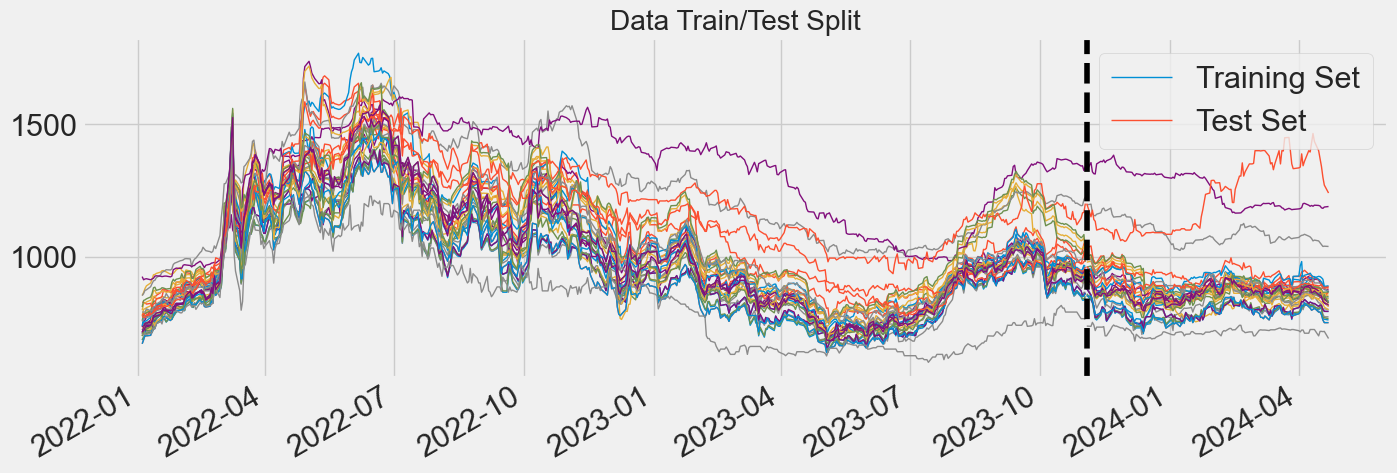

In [11]:
utils.plot_train_test_split(dt_fuel_mg, TARGET_TEST_CUTOFF_DATE)

In [12]:
dt_fuel_mg = utils.create_time_series_features(dt_fuel_mg)
dt_fuel_mg

Fuel Type,Marine Gasoil 1,Marine Gasoil 2,Marine Gasoil 3,Marine Gasoil 4,Marine Gasoil 5,Marine Gasoil 6,Marine Gasoil 7,Marine Gasoil 8,Marine Gasoil 9,Marine Gasoil 10,...,Marine Gasoil 35,Marine Gasoil 36,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
2022-01-04,684.0,670.0,785.0,701.0,700.0,735.0,708.25,777.0,775.5,757.0,...,705.0,715.0,0,1,1,1,2022,4,4,1
2022-01-05,694.0,685.0,785.0,710.0,705.0,755.0,722.25,778.0,800.5,782.0,...,705.0,720.0,0,2,1,1,2022,5,5,1
2022-01-06,698.0,703.0,785.0,711.0,709.0,760.0,715.00,785.0,802.5,784.0,...,705.0,730.0,0,3,1,1,2022,6,6,1
2022-01-07,709.0,700.0,797.0,720.0,715.0,770.0,733.00,786.0,806.5,788.0,...,705.0,740.0,0,4,1,1,2022,7,7,1
2022-01-10,712.0,702.0,790.0,720.0,718.0,795.0,736.00,792.0,813.5,795.0,...,710.0,740.0,0,0,1,1,2022,10,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-16,805.0,790.0,845.0,880.0,808.0,900.0,816.50,911.0,876.5,858.0,...,717.0,853.0,0,1,2,4,2024,107,16,16
2024-04-17,801.0,780.0,845.0,875.0,808.0,900.0,814.50,893.0,865.5,847.0,...,717.0,850.0,0,2,2,4,2024,108,17,16
2024-04-18,765.0,760.0,833.0,865.0,782.0,890.0,799.50,883.0,859.5,841.0,...,716.0,830.0,0,3,2,4,2024,109,18,16
2024-04-19,763.0,750.0,825.0,855.0,772.0,875.0,792.50,884.0,860.5,842.0,...,717.0,825.0,0,4,2,4,2024,110,19,16


In [13]:
train = utils.create_time_series_features(train)
test = utils.create_time_series_features(test)

In [14]:
train.head()

Fuel Type,Marine Gasoil 1,Marine Gasoil 2,Marine Gasoil 3,Marine Gasoil 4,Marine Gasoil 5,Marine Gasoil 6,Marine Gasoil 7,Marine Gasoil 8,Marine Gasoil 9,Marine Gasoil 10,...,Marine Gasoil 35,Marine Gasoil 36,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
2022-01-04,684.0,670.0,785.0,701.0,700.0,735.0,708.25,777.0,775.5,757.0,...,705.0,715.0,0,1,1,1,2022,4,4,1
2022-01-05,694.0,685.0,785.0,710.0,705.0,755.0,722.25,778.0,800.5,782.0,...,705.0,720.0,0,2,1,1,2022,5,5,1
2022-01-06,698.0,703.0,785.0,711.0,709.0,760.0,715.00,785.0,802.5,784.0,...,705.0,730.0,0,3,1,1,2022,6,6,1
2022-01-07,709.0,700.0,797.0,720.0,715.0,770.0,733.00,786.0,806.5,788.0,...,705.0,740.0,0,4,1,1,2022,7,7,1
2022-01-10,712.0,702.0,790.0,720.0,718.0,795.0,736.00,792.0,813.5,795.0,...,710.0,740.0,0,0,1,1,2022,10,10,2


In [15]:
test.head()

Fuel Type,Marine Gasoil 1,Marine Gasoil 2,Marine Gasoil 3,Marine Gasoil 4,Marine Gasoil 5,Marine Gasoil 6,Marine Gasoil 7,Marine Gasoil 8,Marine Gasoil 9,Marine Gasoil 10,...,Marine Gasoil 35,Marine Gasoil 36,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
2023-11-03,854.00,850.0,915.0,915.0,885.0,945.0,878.00,1032.0,978.5,960.0,...,737.0,915.0,0,4,4,11,2023,307,3,44
2023-11-06,835.25,850.0,895.0,915.0,855.0,945.0,853.25,1040.0,982.5,964.0,...,736.0,900.0,0,0,4,11,2023,310,6,45
2023-11-07,825.50,835.0,880.0,905.0,835.0,920.0,827.50,1007.0,967.5,949.0,...,751.0,890.0,0,1,4,11,2023,311,7,45
2023-11-08,795.00,810.0,855.0,890.0,800.0,895.0,813.25,980.0,952.5,934.0,...,741.0,870.0,0,2,4,11,2023,312,8,45
2023-11-09,765.00,780.0,845.0,870.0,780.0,885.0,769.50,972.0,948.5,930.0,...,720.0,850.0,0,3,4,11,2023,313,9,45


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 476 entries, 2022-01-04 to 2023-11-02
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Marine Gasoil 1   476 non-null    float64
 1   Marine Gasoil 2   476 non-null    float64
 2   Marine Gasoil 3   476 non-null    float64
 3   Marine Gasoil 4   476 non-null    float64
 4   Marine Gasoil 5   476 non-null    float64
 5   Marine Gasoil 6   476 non-null    float64
 6   Marine Gasoil 7   476 non-null    float64
 7   Marine Gasoil 8   476 non-null    float64
 8   Marine Gasoil 9   476 non-null    float64
 9   Marine Gasoil 10  476 non-null    float64
 10  Marine Gasoil 11  476 non-null    float64
 11  Marine Gasoil 12  476 non-null    float64
 12  Marine Gasoil 13  476 non-null    float64
 13  Marine Gasoil 14  476 non-null    float64
 14  Marine Gasoil 15  476 non-null    float64
 15  Marine Gasoil 16  476 non-null    float64
 16  Marine Gasoil 17  476 non

In [17]:
train['weekofyear'] = train['weekofyear'].astype('int32')
test['weekofyear'] = test['weekofyear'].astype('int32')

## __1. 'Marine Gasoil'의 평균값__

In [18]:
time_series_features = ['dayofyear', 'dayofweek', 'weekofyear', 'quarter', 'month', 'year']

# 평균값을 계산하여 새로운 대표 변수 생성
train['Marine_Gasoil_Avg'] = train.mean(axis=1)
test['Marine_Gasoil_Avg'] = test.mean(axis=1)

time_series_target = 'Marine_Gasoil_Avg'

X_train = train[time_series_features]
y_train = train[time_series_target]

X_test = test[time_series_features]
y_test = test[time_series_target]

In [19]:
X_train.head()

Fuel Type,dayofyear,dayofweek,weekofyear,quarter,month,year
2022-01-04,4,1,1,1,1,2022
2022-01-05,5,2,1,1,1,2022
2022-01-06,6,3,1,1,1,2022
2022-01-07,7,4,1,1,1,2022
2022-01-10,10,0,2,1,1,2022


In [20]:
y_train.head()

2022-01-04    657.073864
2022-01-05    664.960227
2022-01-06    670.079545
2022-01-07    673.375000
2022-01-10    677.653409
Name: Marine_Gasoil_Avg, dtype: float64

In [21]:
X_test.head()

Fuel Type,dayofyear,dayofweek,weekofyear,quarter,month,year
2023-11-03,307,4,44,4,11,2023
2023-11-06,310,0,45,4,11,2023
2023-11-07,311,1,45,4,11,2023
2023-11-08,312,2,45,4,11,2023
2023-11-09,313,3,45,4,11,2023


In [22]:
y_test.head()

2023-11-03    832.471591
2023-11-06    827.289773
2023-11-07    812.903409
2023-11-08    798.619318
2023-11-09    785.409091
Name: Marine_Gasoil_Avg, dtype: float64

In [23]:
model = utils.train_xgb_regressor(X_train, y_train, X_test, y_test)

[0]	validation_0-rmse:905.62892	validation_1-rmse:761.57059
[100]	validation_0-rmse:343.32955	validation_1-rmse:245.58947
[200]	validation_0-rmse:134.68746	validation_1-rmse:66.30724
[300]	validation_0-rmse:57.31527	validation_1-rmse:44.47799
[318]	validation_0-rmse:49.76554	validation_1-rmse:46.98733


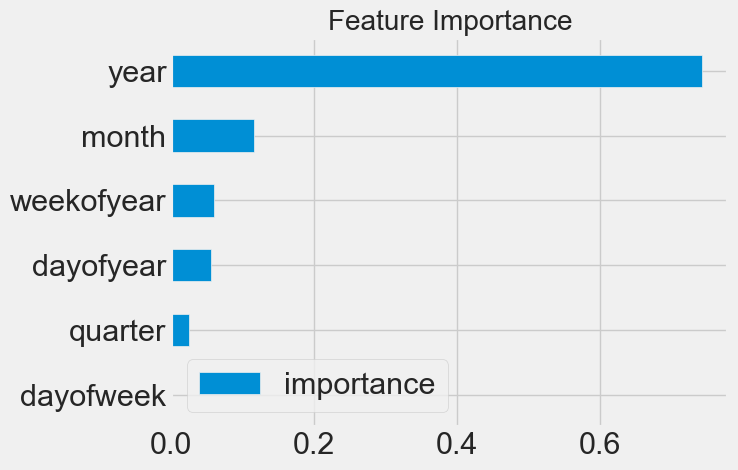

In [24]:
utils.plot_feature_importance(model)

In [25]:
test['prediction'] = model.predict(X_test)
dt_fuel_mg = dt_fuel_mg.merge(test[['prediction']], how='left', left_index=True, right_index=True)
dt_fuel_mg

Fuel Type,Marine Gasoil 1,Marine Gasoil 2,Marine Gasoil 3,Marine Gasoil 4,Marine Gasoil 5,Marine Gasoil 6,Marine Gasoil 7,Marine Gasoil 8,Marine Gasoil 9,Marine Gasoil 10,...,Marine Gasoil 36,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
2022-01-04,684.0,670.0,785.0,701.0,700.0,735.0,708.25,777.0,775.5,757.0,...,715.0,0,1,1,1,2022,4,4,1,NaN
2022-01-05,694.0,685.0,785.0,710.0,705.0,755.0,722.25,778.0,800.5,782.0,...,720.0,0,2,1,1,2022,5,5,1,NaN
2022-01-06,698.0,703.0,785.0,711.0,709.0,760.0,715.00,785.0,802.5,784.0,...,730.0,0,3,1,1,2022,6,6,1,NaN
2022-01-07,709.0,700.0,797.0,720.0,715.0,770.0,733.00,786.0,806.5,788.0,...,740.0,0,4,1,1,2022,7,7,1,NaN
2022-01-10,712.0,702.0,790.0,720.0,718.0,795.0,736.00,792.0,813.5,795.0,...,740.0,0,0,1,1,2022,10,10,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-16,805.0,790.0,845.0,880.0,808.0,900.0,816.50,911.0,876.5,858.0,...,853.0,0,1,2,4,2024,107,16,16,707.654236
2024-04-17,801.0,780.0,845.0,875.0,808.0,900.0,814.50,893.0,865.5,847.0,...,850.0,0,2,2,4,2024,108,17,16,702.977600
2024-04-18,765.0,760.0,833.0,865.0,782.0,890.0,799.50,883.0,859.5,841.0,...,830.0,0,3,2,4,2024,109,18,16,694.981018
2024-04-19,763.0,750.0,825.0,855.0,772.0,875.0,792.50,884.0,860.5,842.0,...,825.0,0,4,2,4,2024,110,19,16,683.754578


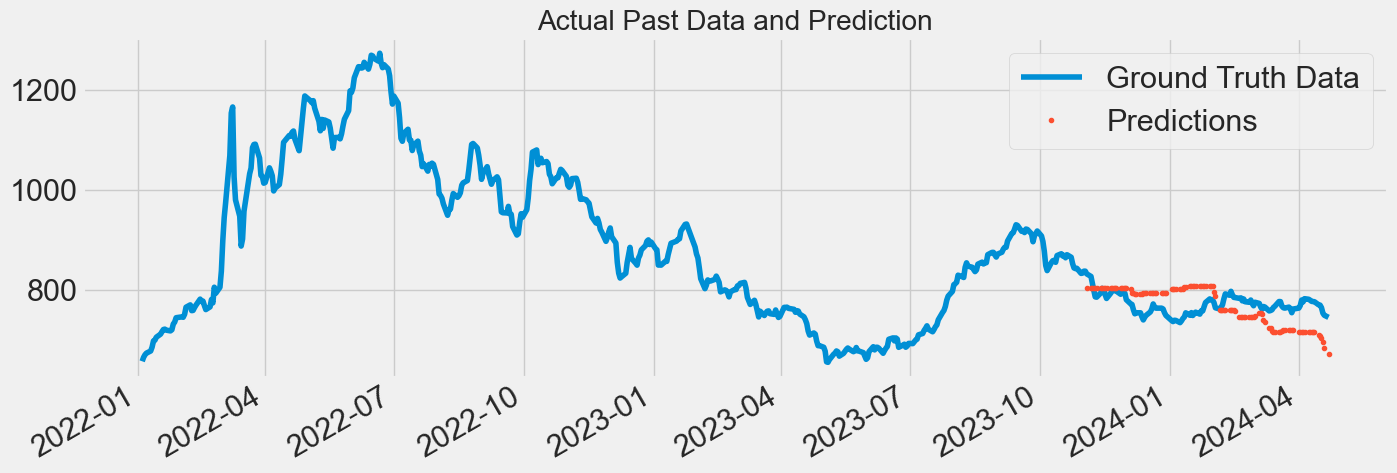

In [26]:
dt_fuel_mg['Marine_Gasoil_Avg'] = dt_fuel_mg.mean(axis=1)
ax = dt_fuel_mg['Marine_Gasoil_Avg'].plot(figsize=(15,5))
dt_fuel_mg['prediction'].plot(ax=ax, style='.')
plt.legend(['Ground Truth Data', 'Predictions'])
ax.set_title('Actual Past Data and Prediction')
plt.show()

In [27]:
score = np.sqrt(mean_squared_error(test['Marine_Gasoil_Avg'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 42.27
